### ES728 – Controle Avançado de Sistemas -  Verão 2021
## PROJETO FINAL - Controle LQR de um Pêndulo Invertido
---

Caio Simão Villela, RA 168342
<br>
Paulo Grego, RA 175559

---

#### Introdução e Motivações

A plataforma escolhida para o desenvolvimento de nosso projeto final fora o **Jupyter-Lab**, um editor WEB para aplicações **Python**. Isso se deu devido à facilidade em criar relatórios dinâmicos e de fácil compreensão, que mostram os outputs de exertos de código em 'tempo real', bem como fotos, hyperlinks, etc.

Ademais disso, o grupo considerou interessante a possibilidade de explorar o desenvolvimento de sistemas de controle em uma linguagem como Python, devido à alta possibilidade de escalonamento e integrabilidade que a plataforma proporciona. Apesar de desafiador, fora uma boa experiência de aprendizado.

O **Pêndulo Invertido** é  um problema clássico de controle que consiste em um carro com movimento livre ao longo de um eixo X, e um pêndulo também livre acoplado a ele. O Projeto de controle visa manipular o as entradas do sistema (forças atuantes no carro) de forma a manter o pêndulo fixo em $\theta = 0$.

<img src="images/pendulo.png" alt="Drawing" style="width: 400px;"/>


---

Imports de bibliotecas necessárias:

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import control.matlab as matlab

from scipy import signal
from numpy.linalg import eig, matrix_rank

Definição de estilos dos gráficos

In [2]:
sns.set_style('whitegrid')
sns.set_palette('colorblind')

---

Declaração de funções:

Serão declaradas abaixo funções úteis, de modo a deixar o código menos poluído.

In [3]:
def plot_step(sys, x0=0, color_index=0, input=None, output=None):
    t, y = control.step_response(sys, X0=x0, T=np.linspace(1, 30, 3000), input=input, output=output)
    
    if len(y.shape) > 1:
        fig, ax = plt.subplots(2, 1, figsize=(12, 8))

        sns.lineplot(x = t, y = y[0], ax=ax[0], label = 'Theta [rad]', color=sns.color_palette('colorblind')[color_index])
        sns.lineplot(x = t, y = y[1], ax=ax[1], label = 'X [m]', color=sns.color_palette('colorblind')[color_index + 1])


        a = ax[0].set_title('Resposta ao Degrau - Ângulo do Pêndulo', size='x-large')
        a = ax[1].set_title('Resposta ao Degrau - Deslocamento', size='x-large')

        a = ax[0].set_ylabel('Theta [rad]')
        a = ax[1].set_ylabel('X [m]')
        a = ax[1].set_xlabel('Tempo [s]')
    
    else:
        fig, ax = plt.subplots(1, 1,figsize=(12, 8))

        sns.lineplot(x = t, y = y, label = 'Theta [rad]', color=sns.color_palette('colorblind')[color_index])

        a = ax.set_title('Resposta ao Degrau - Ângulo do Pêndulo', size='x-large')

        a = ax.set_ylabel('Theta [rad]')
        a = ax.set_ylabel('X [m]')
        a = ax.set_xlabel('Tempo [s]')

In [4]:
def plot_forced(sys, U, T, x0=0, color_index=0):
    t, y, x = control.forced_response(sys, X0=x0, T=T, U=U)
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    sns.lineplot(x = t, y = y[0], ax=ax[0], label = 'Theta [rad]', color=sns.color_palette('colorblind')[color_index])
    sns.lineplot(x = t, y = y[1], ax=ax[1], label = 'X [m]', color=sns.color_palette('colorblind')[color_index + 1])


    a = ax[0].set_title('Resposta ao Degrau com Distúrbio- Ângulo do Pêndulo', size='x-large')
    a = ax[1].set_title('Resposta ao Degrau com Distúrbio- Deslocamento', size='x-large')
    
    a = ax[0].set_ylabel('Theta [rad]')
    a = ax[1].set_ylabel('X [m]')
    a = ax[1].set_xlabel('Tempo [s]')

In [5]:
def gen_fullsys(A, B, C, D, Q):
    R = np.identity(1)
    sys = control.ss(A, B, C, D)
    K_lqr, S, E = control.lqr(sys, Q, R)
    A_lqr = A-B*K_lqr
    C_obs = np.matrix([0, 0, 1, 0])
    polos_obsv = 4 * E
    L = control.acker(A.transpose(), C_obs.transpose(), polos_obsv)
    L = np.transpose(L)
    A_sys = np.concatenate((np.concatenate((A_lqr,  B*K_lqr), axis=1), np.concatenate((np.zeros((4, 4)), A-L*C_obs), axis=1)), axis=0)
    B_sys = np.concatenate((B, np.zeros((4, 1))), axis=0)
    C_sys = np.concatenate((C, np.zeros((2,4))), axis=1)
    D_sys = np.matrix([[0], [0]])
    sys_final = control.ss(A_sys, B_sys, C_sys, D_sys)
    return sys_final

---

## Formulação do Sistema

As matrizes de estado são definidas conforme o enunciado:

In [6]:
A = np.matrix([[0, 1, 0, 0], [16.0976, 0, 0, 0], [0, 0, 0, 1], [-0.73177, 0, 0, 0]])
B = np.matrix([[0], [-0.1463], [0], [0.0976]])
C = np.matrix([[1, 0, 0, 0], [0, 0, 1, 0]])
D = np.matrix([[0], [0]])

De forma que:

$$
\dot{x} = Ax + Bu
$$

$$
y = Cx + Du
$$

Checa-se então a controlabilidade e observabilidade do sistema:

In [7]:
print('Rank da matriz de controlabilidade = ', matrix_rank(control.ctrb(A, B)))
print('Rank da matriz de observabilidade = ', matrix_rank(control.obsv(A, C)))

Rank da matriz de controlabilidade =  4
Rank da matriz de observabilidade =  4


Como o sistema é observável e controlável, seguimos para as próximas etapas.

##### Definição do State Space:

In [8]:
sys = control.ss(A, B, C, D)

Checa-se os polos os sistema por dois meios, de forma a debugar a formação do sistema

In [9]:
print(sys.pole())
print(eig(A)[0])

[ 0.          0.          4.01218145 -4.01218145]
[ 0.          0.          4.01218145 -4.01218145]


Após atestarmos que o sistema se comporta da forma esperada, observa-se o autovalor positivo 4.01218145, que indica que o sistema é instável.<br>
Plota-se a resposta do sistema livre ao degrau.

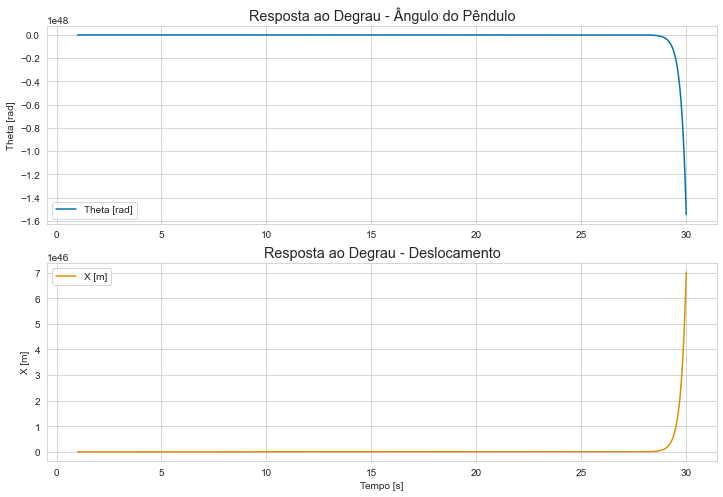

In [10]:
plot_step(sys)

---
### Posicionamento de Polos

O controle do nosso sistema pode ser feito por manipulações algébricas que definem a localização desejada de seus polos a partir de uma matriz de ganhos K.
<br>
Inicialmente o estado do sistema encontra-se na forma:

$$
\dot{x} =  Ax + Bu
$$

Após introduzirmos um ganho K que posiciona os polos no local desejado, obtemos:

$$
    u = -Kx
$$
$$
\dot{x} =  (A-BK)x 
$$


É possível setar os polos do sistema em locais arbitrários, de forma a testar seu novo comportamento. Escolhem-se autovalores negativos genéricos para tal, fazendo-se uso da função **control.place()**


In [11]:
K = control.place(A, B, [-10, -2, -3, -4])

A_k = (A-B*K)
sys_k = control.ss(A_k, B, C, D)

Definida a nova matriz A, simula-se novamente a resposta do sistema ao degrau:

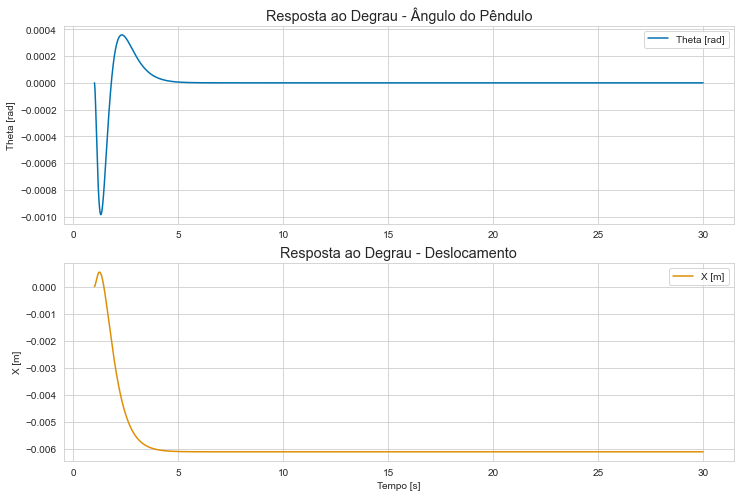

In [12]:
plot_step(sys_k)

Percebe-se que o sistema tem agora uma resposta de fato estável, no entanto nada otimizada.

---

## Controle LQR

O método de controle LQR não passa de uma função de custos, que visa diminuir ao máximo nosso Performace Index, J.

$$
J = \int_0^\infty (X^TQX + u^TRu)dt
$$

Ao introduzir as matrizes Q e R, define-se "penalidades" para diferenças observadas em cada um dos estados do sistema. Elas são escolhidas pelo método sugerido no material complementar disponibilizado:

In [34]:
Q = C.T*C
R = np.identity(1)

Nosso controle LQR pode ser obtido pela função  **control.lqr()**, que retorna o ganho **K**, a solução **S** da equação de Riccati, e os autovalores **E** do sistema de malha fechada.

In [35]:
K_lqr, S, E = control.lqr(sys, Q, R)

<br>

In [36]:
print('K_lqr = ', K_lqr)

K_lqr =  [[-244.75328676  -61.22658528   -1.           -5.18890327]]


<br>

In [40]:
# rho = [1e-3, 1e-2, 1e-1, 1]

# for r in rho:
#     K, S, E = control.lqr(sys, Q, r)
#     print(K)

Analisando os autovetores obtidos pelo controle lqr, vemos que o sistema se estabiliza devido aos polos complexos com parte real negativa.

In [17]:
print('Autovelores de Malha Fechada = \n', [e for e in E])

Autovelores de Malha Fechada = 
 [(-4.0122185+0.018250389j), (-4.0122185-0.018250389j), (-0.21328796+0.21319976j), (-0.21328796-0.21319976j)]


<br>

Criando-se agora nosso sistema controlado em espaços de estado, a partir da nova matriz:

$$
A_{lqr} = A-B*K_{lqr}
$$

Checa-se também seus autovelores, que devem ser iguais aos polos mostrados anteriormente.

In [18]:
A_lqr = A-B*K_lqr
print(eig(A_lqr)[0])

[-4.01221827+0.01825039j -4.01221827-0.01825039j -0.21328796+0.21319977j
 -0.21328796-0.21319977j]


In [19]:
sys_lqr = control.ss(A_lqr, B, C, D)

<br>

Como esperado de nosso sistema, dado como entrada uma resposta ao degrau, há estabilização por volta dos 20 segundos:

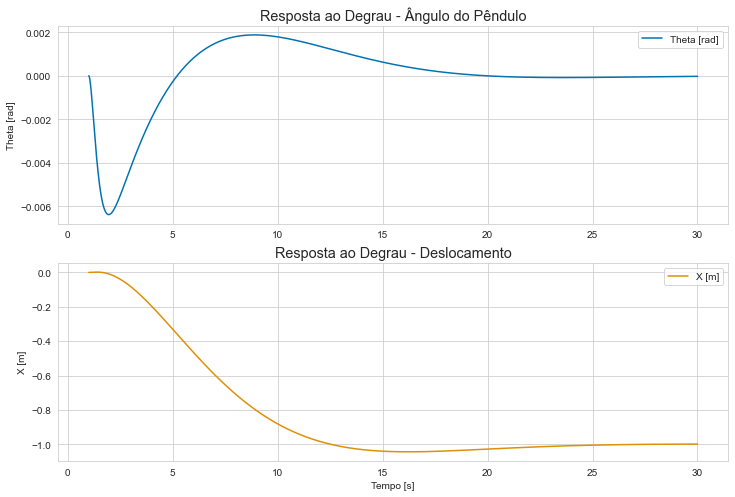

In [20]:
plot_step(sys_lqr)

Testando agora para condições iniciais **não nulas**, de modo que:

$$
X_{0} = 1 (m)
$$

$$
\theta_{0} = 0.1 (rad)
$$


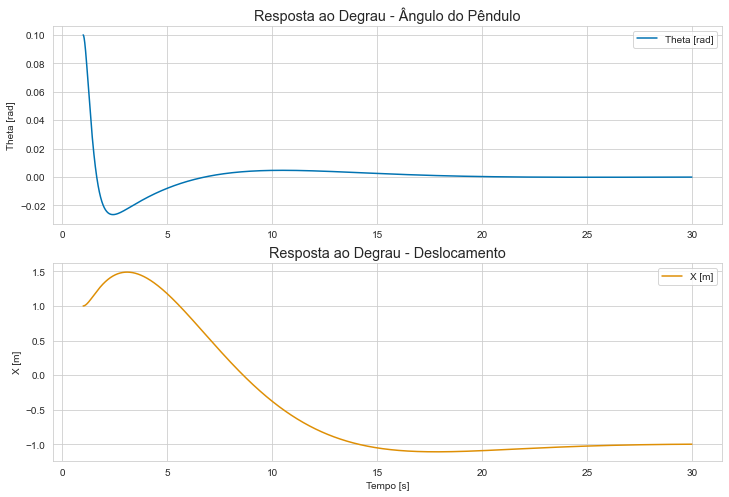

In [21]:
plot_step(sys_lqr, x0=[0.1, 0, 1, 0])

<br>

Simula-se agora a resposta do sistema ao degrau, considerando-se um **distúrbio** na entrada $U$ do sistema, aplicado aos 45s.
<br><br>
Considerou-se uma entrada $U$, além de condições iniciais $X_{0}$ tal que nossa resposta ao sistema fosse semelhante à apresentada no material de auxílio ao projeto.
<br>
Sendo assim, as condições iniciais são nulas e considera-se um step de valor -1 introduzido aos 45s de simulação:

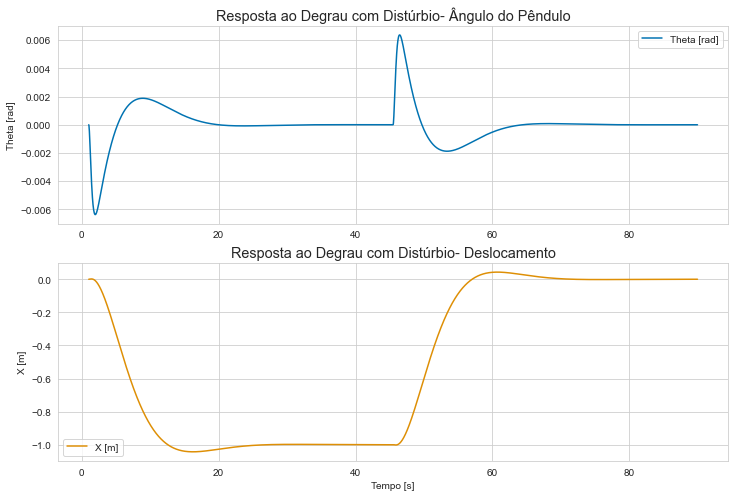

In [22]:
T = np.linspace(1, 90, 3000)
U = [1 if t < len(T)/2 else 0 for t in range(len(T))]

plot_forced(sys_lqr, T=T, U=U)

---

### Projeto de Observador

Primeiro atesta-se a observabilidade do sistema dadas as novas matrizes de observação:

In [23]:
print('Rank da matriz de observabilidade = ', matrix_rank(control.obsv(A, [1, 0, 0, 0])))

Rank da matriz de observabilidade =  2


In [24]:
print('Rank da matriz de observabilidade = ', matrix_rank(control.obsv(A, [0, 0, 1, 0])))

Rank da matriz de observabilidade =  4


Nota-se que a primeira matriz faz com que o sistema não seja observável, visto que ela não tem o mesmo span da nossa matriz de estados. Já pela segunda matriz, nosso sistema é observável.

In [25]:
C_obs = np.matrix([0, 0, 1, 0])

<br>

Sabemos que os polos do nosso sistema, dados pelo controlador, são:

In [26]:
print(E)

[-4.0122185 +0.01825039j -4.0122185 -0.01825039j -0.21328796+0.21319976j
 -0.21328796-0.21319976j]


Queremos que os polos do nosso observador sejam, pelo menos, 3x mais rápidos aos polos do observador. Vamos multiplicá-los por 4:

In [28]:
polos_obsv = 4 * E
print(polos_obsv)

[-16.048874  +0.07300156j -16.048874  -0.07300156j
  -0.85315186+0.85279906j  -0.85315186-0.85279906j]


Faremos agora uso do comando **acker()** de nossa biblioteca, de forma a obter uma matriz de ganhos para setar os polos de nosso observador.

Note que usaremos as matrizes $A'$ e $C'$ para o cálculo de nosso ganho L, de forma análoga ao uso das matrizes $A$ e $B$ para o ganho do observador.

In [32]:
L = control.acker(A.transpose(), C_obs.transpose(), polos_obsv)
L = np.transpose(L)
L

matrix([[-1408.04647666],
        [-7769.2248085 ],
        [   33.80405426],
        [  329.8929186 ]])

Nossas matrizes do espaço de estados se tornam, portando:


$$
A_{sys} = \begin{pmatrix}
A -BK & BK\\
0 & A-LC
\end{pmatrix}
$$

$$
B_{sys} = \begin{pmatrix}
B\\
0
\end{pmatrix}
$$

$$
C_{sys} = \begin{pmatrix}
C & 0
\end{pmatrix}
$$

In [33]:
A_sys = np.concatenate((np.concatenate((A_lqr,  B*K_lqr), axis=1), np.concatenate((np.zeros((4, 4)), A-L*C_obs), axis=1)), axis=0)
B_sys = np.concatenate((B, np.zeros((4, 1))), axis=0)
C_sys = np.concatenate((C, np.zeros((2,4))), axis=1)
D_sys = np.matrix([[0], [0]])

Declarando o sistema final com observador:

In [29]:
sys_final = control.ss(A_sys, B_sys, C_sys, D_sys)

São então plotadas as respostas do nosso sistema para: condições iniciais nulas, condições iniciais não nulas e considerando-se um distúrbio:

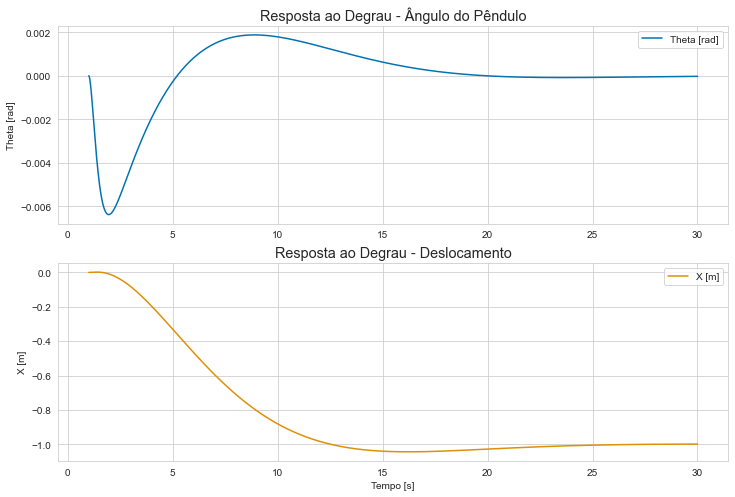

In [30]:
plot_step(sys_final)

Testando agora para condições iniciais **não nulas**, de modo que:

$$
X_{0} = 1 (m)
$$

$$
\theta_{0} = 0.1 (rad)
$$


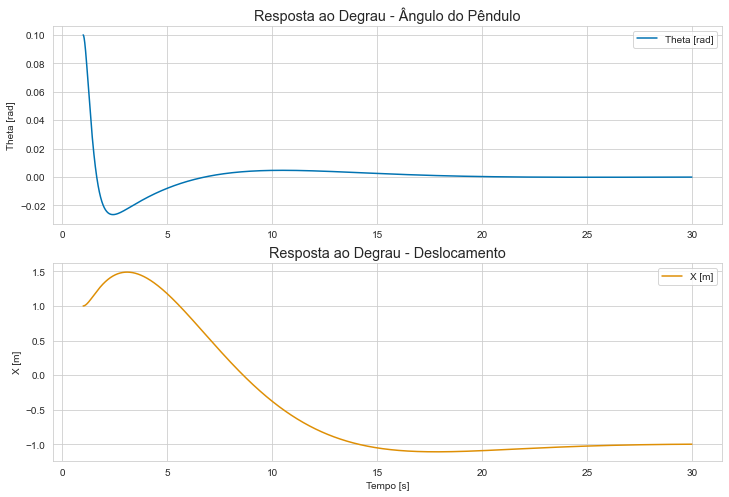

In [31]:
plot_step(sys_final, x0=[0.1, 0, 1, 0, 0, 0, 0, 0])

<br>

Simula-se agora a resposta do sistema ao degrau, considerando-se um **distúrbio** na entrada $U$ do sistema, aplicado aos 45s.
<br><br>
Considerou-se uma entrada $U$, além de condições iniciais $X_{0}$ tal que nossa resposta ao sistema fosse semelhante à apresentada no material de auxílio ao projeto.
<br>
Sendo assim, as condições iniciais são nulas e considera-se um step de valor -1 introduzido aos 45s de simulação:

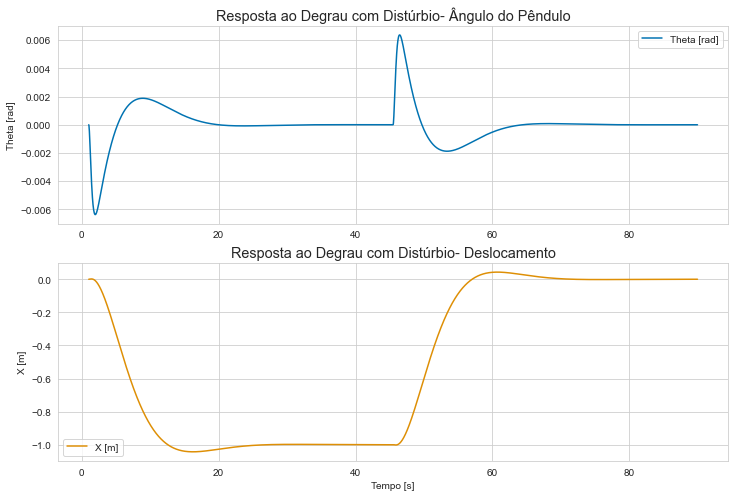

In [32]:
T = np.linspace(1, 90, 3000)
U = [1 if t < len(T)/2 else 0 for t in range(len(T))]

plot_forced(sys_final, T=T, U=U)

Observa-se que as respostas ao impulso do sistema final com observador são virtualmente as mesmas às do sistema com controlador LQR. Isso significa que os polos de nosso observador são rápidos o suficiente para lidar com a simulação, logo nossos pré requisitos de projeto foram cumpridos com sucesso.

Realizando uma comparação dos sinais de saída entre os sistemas com e sem observador:

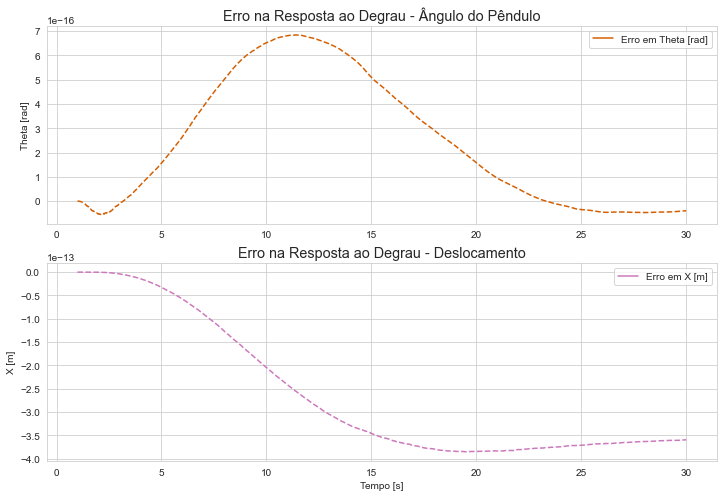

In [33]:
t, y_lqr = control.step_response(sys_lqr, T=np.linspace(1, 30, 3000))
t, y_final = control.step_response(sys_final, T=np.linspace(1, 30, 3000))

erro = y_final-y_lqr


color_index = 3
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.lineplot(x = t, y = erro[0], ax=ax[0], label = 'Erro em Theta [rad]', color=sns.color_palette('colorblind')[color_index])
sns.lineplot(x = t, y = erro[1], ax=ax[1], label = 'Erro em X [m]', color=sns.color_palette('colorblind')[color_index + 1], dashes=True)


a = ax[0].set_title('Erro na Resposta ao Degrau - Ângulo do Pêndulo', size='x-large')
a = ax[1].set_title('Erro na Resposta ao Degrau - Deslocamento', size='x-large')

a = ax[0].set_ylabel('Theta [rad]')
a = ax[1].set_ylabel('X [m]')
a = ax[1].set_xlabel('Tempo [s]')

ax[0].lines[0].set_linestyle("--")
ax[1].lines[0].set_linestyle("--")

Percebe-se que o erro notado tanto em $\theta$ quanto em X é basicamente nulo.

---

### Alterando-se valores da matriz de ponderação Q diagonal.

A matriz de ponderação $Q$ pode ser alterada de modo a antigirmos nossos parâmetros para o design da fase transiente do sistema. Inicialmente, ela foi declarada da seguinte forma:

In [34]:
Q

matrix([[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]])

<br>

Primeiramente vamos aferir o peso de interferirmos nas velocidades angulares e lineares do sistema:

Q = 
 [[ 1  0  0  0]
 [ 0 10  0  0]
 [ 0  0  1  0]
 [ 0  0  0 10]]


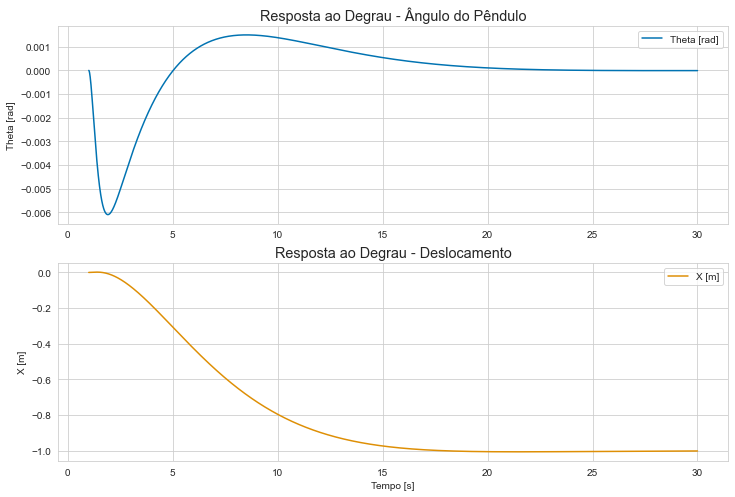

In [35]:
Q[0, 0] = 1
Q[1, 1] = 10
Q[2, 2] = 1
Q[3, 3] = 10

print('Q = \n', Q)

sys_q = gen_fullsys(A, B, C, D, Q)
plot_step(sys_q)

Percebe-se que a saída do sistema é muito próxima à saída que desconsidera as velocidades dos pesos na matriz Q. Isso pois nossos estados 2 e 4 não são considerados no nosso sistema inicial. Com o uso de nosso observador, podemos aferir seus valores, no entanto isso pode gerar erros devido a ruidos e comportamentos imprevisíveis que não são desejados no projeto. Sendo assim, não alteraremos seus valores.

Q = 
 [[10  0  0  0]
 [ 0  0  0  0]
 [ 0  0 10  0]
 [ 0  0  0  0]]


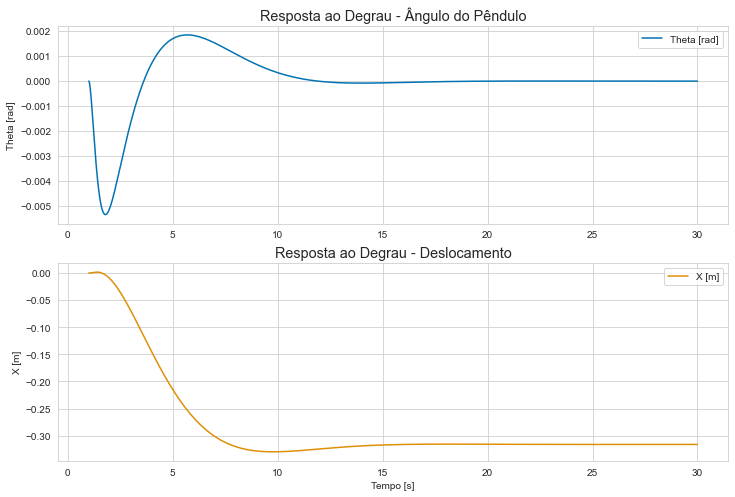

In [36]:
Q[0, 0] = 10
Q[1, 1] = 0
Q[2, 2] = 10
Q[3, 3] = 0

print('Q = \n', Q)

sys_q = gen_fullsys(A, B, C, D, Q)
plot_step(sys_q)

Q = 
 [[100   0   0   0]
 [  0   0   0   0]
 [  0   0 100   0]
 [  0   0   0   0]]


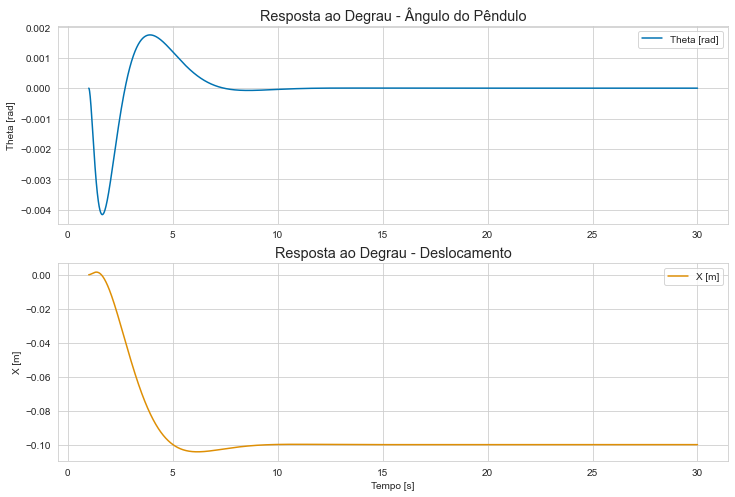

In [37]:
Q[0, 0] = 100
Q[1, 1] = 0
Q[2, 2] = 100
Q[3, 3] = 0

print('Q = \n', Q)

sys_q = gen_fullsys(A, B, C, D, Q)
plot_step(sys_q)

Q = 
 [[1000    0    0    0]
 [   0    0    0    0]
 [   0    0 1000    0]
 [   0    0    0    0]]


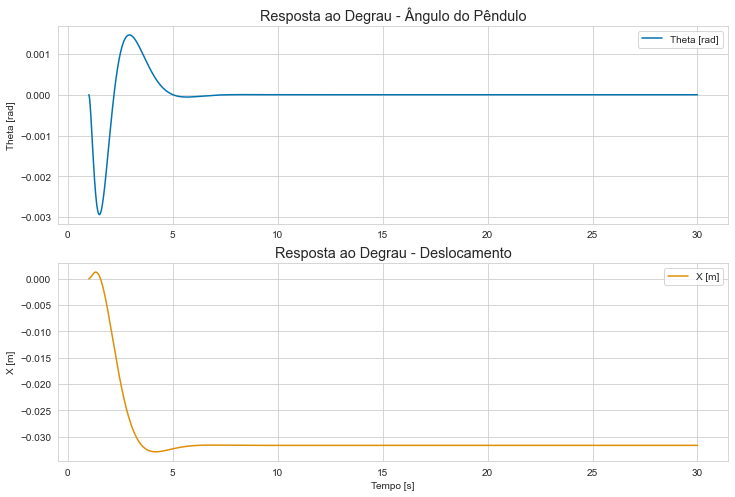

In [38]:
Q[0, 0] = 1000
Q[1, 1] = 0
Q[2, 2] = 1000
Q[3, 3] = 0

print('Q = \n', Q)

sys_q = gen_fullsys(A, B, C, D, Q)
plot_step(sys_q)

Aumentando os valores da matriz apenas para os estados $X$ e $\theta$ gera uma resposta mais rápida do sistema ao impulso. Percebe-se que ao incrementarmos os valores de Q[0, 0] e Q[1, 1] o sistema estabiliza bem mais rapidamente. O limite para esses valores em um sistema físico ocorreria devido ao motor que utilizarmos para produzir nosso input $U$, visto que necessariamos de mais torque e energia disponíveis para alcançar essa resposta.

Abaixo temos uma resposta boa o suficiente para nossos parâmetros, com fase transiente e overshoot aceitáveis:

Q = 
 [[ 100    0    0    0]
 [   0    0    0    0]
 [   0    0 1000    0]
 [   0    0    0    0]]


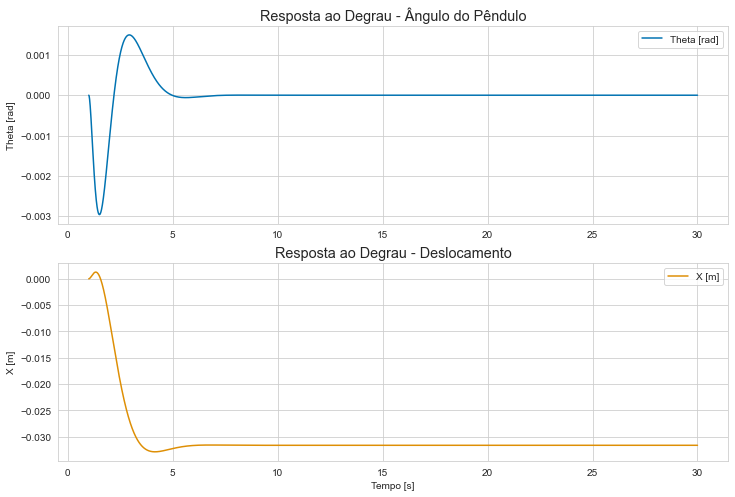

In [39]:
Q[0, 0] = 100
Q[1, 1] = 0
Q[2, 2] = 1000
Q[3, 3] = 0

print('Q = \n', Q)

sys_q = gen_fullsys(A, B, C, D, Q)
plot_step(sys_q)